# Hyperparameter Tuning

<br>
<div style="background-color: #F8AE29; text-align: left; width: 120%; height: 2px;"></div>
<br>

In [3]:
import xgboost as xgb
from xgboost import XGBClassifier
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, roc_auc_score, log_loss

import wandb
from wandb.sklearn import plot_precision_recall, plot_feature_importances
from wandb.sklearn import plot_class_proportions, plot_learning_curve, plot_roc

import warnings 
warnings.filterwarnings('ignore')

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestClassifier

from sklearn.inspection import permutation_importance

from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import SelectKBest

from sklearn.decomposition import PCA

from sklearn import config_context

import os

import circlify
import plotly.express as px

import joblib

In [4]:
selected_features = [
    "Married", "Never-married", "Bachelors", "Masters", "HS-grad", 
    "Capital-gain", "Exec-managerial", "Other-service", 
    "Own-child", "Unmarried", "Male"
]

bankA_data = pd.read_csv("BankA_Clean.csv")
bankB_data = pd.read_csv("BankB_Clean.csv")
bankC_data = pd.read_csv("BankC_Clean.csv")

In [215]:
combined_data = pd.concat([bankA_data, bankB_data, bankC_data], axis=0)

combined_data["income"] = combined_data["income"].astype(int)

print(f"Shape of combined data: {combined_data.shape}")

Shape of combined data: (799999, 97)


In [6]:
column_mapping = {
    "marital-status_Married-civ-spouse": "Married",
    "marital-status_Never-married": "Never-married",
    "education_Bachelors": "Bachelors",
    "education_Masters": "Masters",
    "education_HS-grad": "HS-grad",
    "capital-gain": "Capital-gain",
    "occupation_Exec-managerial": "Exec-managerial",
    "occupation_Other-service": "Other-service",
    "relationship_Own-child": "Own-child",
    "relationship_Unmarried": "Unmarried",
    "sex_Male": "Male",
}


In [7]:
combined_data.rename(columns=column_mapping, inplace=True)

selected_columns = list(column_mapping.values()) + ["income"]
combined_data = combined_data[selected_columns]


In [16]:
combined_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 799999 entries, 0 to 170619
Data columns (total 12 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   Married          799999 non-null  float64
 1   Never-married    799999 non-null  float64
 2   Bachelors        799999 non-null  float64
 3   Masters          799999 non-null  float64
 4   HS-grad          799999 non-null  float64
 5   Capital-gain     799999 non-null  float64
 6   Exec-managerial  799999 non-null  float64
 7   Other-service    799999 non-null  float64
 8   Own-child        799999 non-null  float64
 9   Unmarried        799999 non-null  float64
 10  Male             799999 non-null  float64
 11  income           799999 non-null  int64  
dtypes: float64(11), int64(1)
memory usage: 79.3 MB


<hr>

In [11]:
def train_run(X_train, y_train, X_val, y_val, params, num_boost_round=100):
    dtrain = xgb.DMatrix(X_train, label=y_train)
    dval = xgb.DMatrix(X_val, label=y_val)

    bst = xgb.train(
        params,
        dtrain,
        num_boost_round=num_boost_round,
        evals=[(dtrain, "train"), (dval, "val")],
        early_stopping_rounds=10,
        verbose_eval=0,
    )

    y_val_preds = bst.predict(dval)
    auc_val = roc_auc_score(y_val, y_val_preds)

    return {"model": bst, "auc": auc_val, "params": params}


def multiple_runs(X_train, y_train, X_val, y_val, run_configs):
    results = []
    for config in run_configs:
        print(f"Training mit Parametern: {config}")
        result = train_run(X_train, y_train, X_val, y_val, config)
        results.append(result)
        print(f"AUC: {result['auc']:.4f}")
    return results


def plot_results(results):
    aucs = [res["auc"] for res in results]
    depths = [res["params"]["max_depth"] for res in results]
    learning_rates = [res["params"]["learning_rate"] for res in results]

    plt.figure(figsize=(10, 6))
    plt.scatter(depths, aucs, c=learning_rates, cmap="viridis", s=100, alpha=0.7)
    plt.colorbar(label="Learning Rate")
    plt.xlabel("Max Depth")
    plt.ylabel("Validation AUC")
    plt.title("Hyperparameter Tuning Results")
    plt.show()



In [12]:
X = combined_data[selected_features]
y = combined_data["income"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [30]:
run_configs = [
    # First runs
    {"objective": "binary:logistic", "eval_metric": "auc", "max_depth": 3, "learning_rate": 0.1, "subsample": 0.8},
    {"objective": "binary:logistic", "eval_metric": "auc", "max_depth": 5, "learning_rate": 0.1, "subsample": 0.8},
    {"objective": "binary:logistic", "eval_metric": "auc", "max_depth": 5, "learning_rate": 0.05, "subsample": 0.8},
    {"objective": "binary:logistic", "eval_metric": "auc", "max_depth": 7, "learning_rate": 0.05, "subsample": 0.8},
    
    # New Runs
    {"objective": "binary:logistic", "eval_metric": "auc", "max_depth": 5, "learning_rate": 0.01, "subsample": 0.8},
    {"objective": "binary:logistic", "eval_metric": "auc", "max_depth": 7, "learning_rate": 0.01, "subsample": 0.8},
    
    # Variations with Subsamples
    {"objective": "binary:logistic", "eval_metric": "auc", "max_depth": 5, "learning_rate": 0.1, "subsample": 0.6},
    {"objective": "binary:logistic", "eval_metric": "auc", "max_depth": 5, "learning_rate": 0.1, "subsample": 1.0},
    
    # Adding regularization
    {"objective": "binary:logistic", "eval_metric": "auc", "max_depth": 5, "learning_rate": 0.05, "subsample": 0.8, "reg_alpha": 0.1, "reg_lambda": 1.0},
    {"objective": "binary:logistic", "eval_metric": "auc", "max_depth": 7, "learning_rate": 0.05, "subsample": 0.8, "reg_alpha": 0.1, "reg_lambda": 1.0}
]



In [31]:
results = multiple_runs(X_train, y_train, X_test, y_test, run_configs)

Training mit Parametern: {'objective': 'binary:logistic', 'eval_metric': 'auc', 'max_depth': 3, 'learning_rate': 0.1, 'subsample': 0.8}
AUC: 0.8811
Training mit Parametern: {'objective': 'binary:logistic', 'eval_metric': 'auc', 'max_depth': 5, 'learning_rate': 0.1, 'subsample': 0.8}
AUC: 0.8849
Training mit Parametern: {'objective': 'binary:logistic', 'eval_metric': 'auc', 'max_depth': 5, 'learning_rate': 0.05, 'subsample': 0.8}
AUC: 0.8821
Training mit Parametern: {'objective': 'binary:logistic', 'eval_metric': 'auc', 'max_depth': 7, 'learning_rate': 0.05, 'subsample': 0.8}
AUC: 0.8847
Training mit Parametern: {'objective': 'binary:logistic', 'eval_metric': 'auc', 'max_depth': 5, 'learning_rate': 0.01, 'subsample': 0.8}
AUC: 0.8776
Training mit Parametern: {'objective': 'binary:logistic', 'eval_metric': 'auc', 'max_depth': 7, 'learning_rate': 0.01, 'subsample': 0.8}
AUC: 0.8820
Training mit Parametern: {'objective': 'binary:logistic', 'eval_metric': 'auc', 'max_depth': 5, 'learning_ra

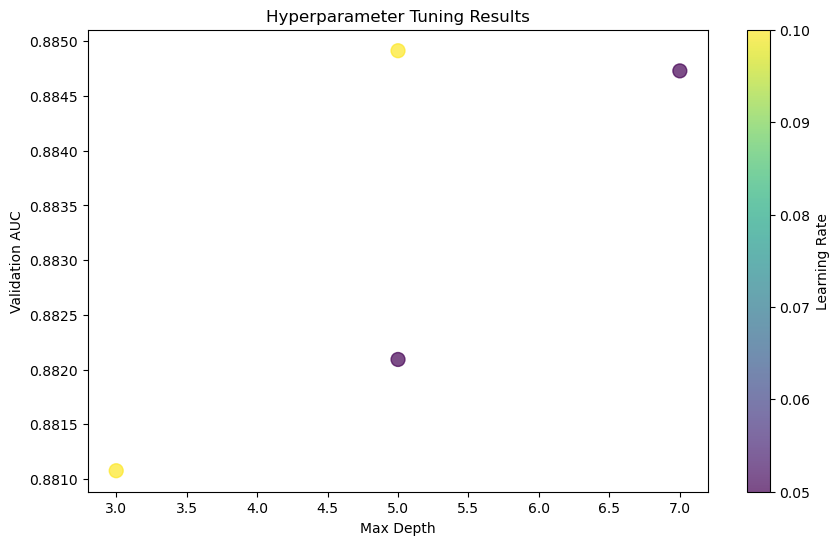

In [15]:
plot_results(results)

In [129]:
run_2_configs = [
    {"objective": "binary:logistic", "eval_metric": "auc", "max_depth": 5, "learning_rate": 0.15, "subsample": 0.8},
    {"objective": "binary:logistic", "eval_metric": "auc", "max_depth": 7, "learning_rate": 0.1, "subsample": 0.8},
    {"objective": "binary:logistic", "eval_metric": "auc", "max_depth": 5, "learning_rate": 0.15, "subsample": 0.6},
    {'objective': 'binary:logistic', 'eval_metric': 'auc', 'max_depth': 5, 'learning_rate': 0.1, 'subsample': 0.7},
    {"objective": "binary:logistic", "eval_metric": "auc", "max_depth": 7, "learning_rate": 0.1, "subsample": 0.7, "reg_alpha": 0.1, "reg_lambda": 1.0}
]

In [35]:
results2 = multiple_runs(X_train, y_train, X_test, y_test, run_2_configs)

Training mit Parametern: {'objective': 'binary:logistic', 'eval_metric': 'auc', 'max_depth': 5, 'learning_rate': 0.15, 'subsample': 0.8}
AUC: 0.8859
Training mit Parametern: {'objective': 'binary:logistic', 'eval_metric': 'auc', 'max_depth': 7, 'learning_rate': 0.1, 'subsample': 0.8}
AUC: 0.8861
Training mit Parametern: {'objective': 'binary:logistic', 'eval_metric': 'auc', 'max_depth': 5, 'learning_rate': 0.15, 'subsample': 0.6}
AUC: 0.8859
Training mit Parametern: {'objective': 'binary:logistic', 'eval_metric': 'auc', 'max_depth': 5, 'learning_rate': 0.1, 'subsample': 0.7}
AUC: 0.8851
Training mit Parametern: {'objective': 'binary:logistic', 'eval_metric': 'auc', 'max_depth': 7, 'learning_rate': 0.1, 'subsample': 0.7, 'reg_alpha': 0.1, 'reg_lambda': 1.0}
AUC: 0.8861


In [38]:
run_3_configs = [
    {"objective": "binary:logistic", "eval_metric": "auc", "max_depth": 7, "learning_rate": 0.13, "subsample": 0.75},
    {"objective": "binary:logistic", "eval_metric": "auc", "max_depth": 7, "learning_rate": 0.14, "subsample": 0.85},
    {"objective": "binary:logistic", "eval_metric": "auc", "max_depth": 6, "learning_rate": 0.1, "subsample": 0.85},
    {"objective": "binary:logistic", "eval_metric": "auc", "max_depth": 6, "learning_rate": 0.11, "subsample": 0.85},
    {"objective": "binary:logistic", "eval_metric": "auc", "max_depth": 8, "learning_rate": 0.1, "subsample": 0.65},

    {"objective": "binary:logistic", "eval_metric": "auc", "max_depth": 7, "learning_rate": 0.13, "subsample": 0.85, "reg_alpha": 0.08, "reg_lambda": 1.0},
    {"objective": "binary:logistic", "eval_metric": "auc", "max_depth": 8, "learning_rate": 0.1, "subsample": 0.75, "reg_alpha": 0.09, "reg_lambda": 1.0},
    {"objective": "binary:logistic", "eval_metric": "auc", "max_depth": 6, "learning_rate": 0.14, "subsample": 0.95, "reg_alpha": 0.1, "reg_lambda": 1.0},
    {"objective": "binary:logistic", "eval_metric": "auc", "max_depth": 7, "learning_rate": 0.15, "subsample": 0.75, "reg_alpha": 0.15, "reg_lambda": 1.0},
    {"objective": "binary:logistic", "eval_metric": "auc", "max_depth": 7, "learning_rate": 0.12, "subsample": 0.95, "reg_alpha": 0.2, "reg_lambda": 1.0},
]
results3 = multiple_runs(X_train, y_train, X_test, y_test, run_3_configs)

Training mit Parametern: {'objective': 'binary:logistic', 'eval_metric': 'auc', 'max_depth': 7, 'learning_rate': 0.13, 'subsample': 0.75}
AUC: 0.8863
Training mit Parametern: {'objective': 'binary:logistic', 'eval_metric': 'auc', 'max_depth': 7, 'learning_rate': 0.14, 'subsample': 0.85}
AUC: 0.8863
Training mit Parametern: {'objective': 'binary:logistic', 'eval_metric': 'auc', 'max_depth': 6, 'learning_rate': 0.1, 'subsample': 0.85}
AUC: 0.8855
Training mit Parametern: {'objective': 'binary:logistic', 'eval_metric': 'auc', 'max_depth': 6, 'learning_rate': 0.11, 'subsample': 0.85}
AUC: 0.8857
Training mit Parametern: {'objective': 'binary:logistic', 'eval_metric': 'auc', 'max_depth': 8, 'learning_rate': 0.1, 'subsample': 0.65}
AUC: 0.8863
Training mit Parametern: {'objective': 'binary:logistic', 'eval_metric': 'auc', 'max_depth': 7, 'learning_rate': 0.13, 'subsample': 0.85, 'reg_alpha': 0.08, 'reg_lambda': 1.0}
AUC: 0.8862
Training mit Parametern: {'objective': 'binary:logistic', 'eval_

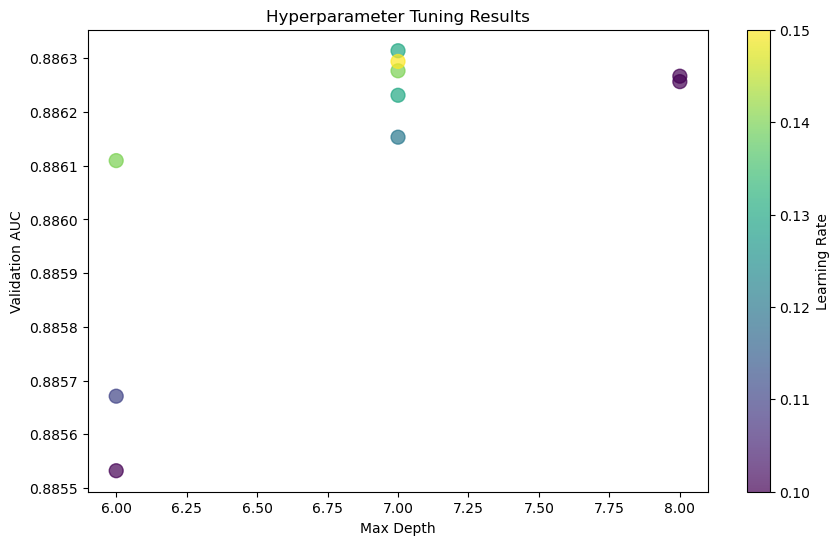

In [39]:
plot_results(results3)

<h>

In [17]:
aucs = [res["auc"] for res in results]
depths = [res["params"]["max_depth"] for res in results]
learning_rates = [res["params"]["learning_rate"] for res in results]

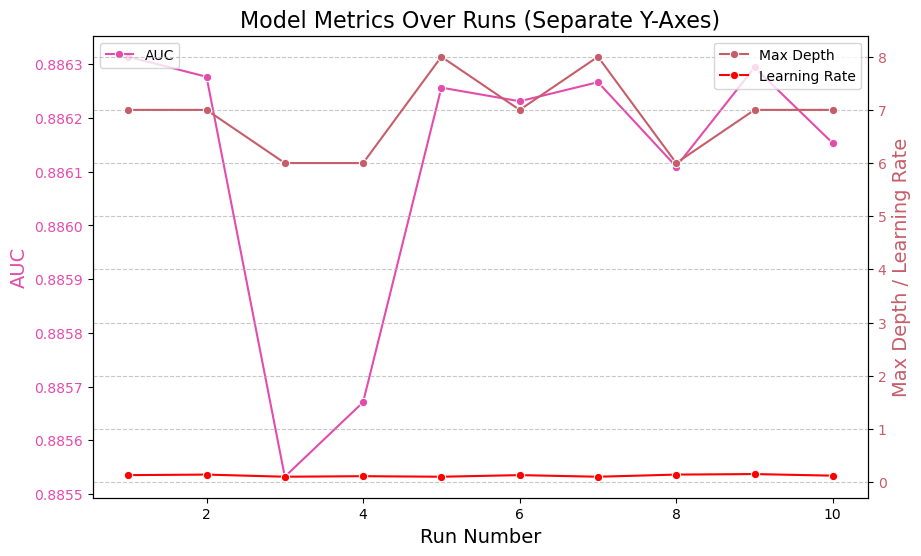

In [40]:
aucs = [res["auc"] for res in results3]
depths = [res["params"]["max_depth"] for res in results3]
learning_rates = [res["params"]["learning_rate"] for res in results3]

results3_df = pd.DataFrame({
    "Run": range(1, len(results3) + 1),
    "AUC": aucs,
    "Max Depth": depths,
    "Learning Rate": learning_rates,
})

fig, ax1 = plt.subplots(figsize=(10, 6))

ax1.set_xlabel("Run Number", fontsize=14)
ax1.set_ylabel("AUC", fontsize=14, color="#e34cac")
sns.lineplot(x=results3_df["Run"], y=results3_df["AUC"], ax=ax1, marker="o", color="#e34cac", label="AUC")
ax1.tick_params(axis='y', labelcolor="#e34cac")
ax1.legend(loc="upper left")

ax2 = ax1.twinx()
ax2.set_ylabel("Max Depth / Learning Rate", fontsize=14, color="#c65e6a")
sns.lineplot(x=results3_df["Run"], y=results3_df["Max Depth"], ax=ax2, marker="o", color="#c65e6a", label="Max Depth")
sns.lineplot(x=results3_df["Run"], y=results3_df["Learning Rate"], ax=ax2, marker="o", color="red", label="Learning Rate")
ax2.tick_params(axis='y', labelcolor="#c65e6a")
ax2.legend(loc="upper right")

plt.title("Model Metrics Over Runs (Separate Y-Axes)", fontsize=16)
plt.grid(True, linestyle="--", alpha=0.7)
plt.show()


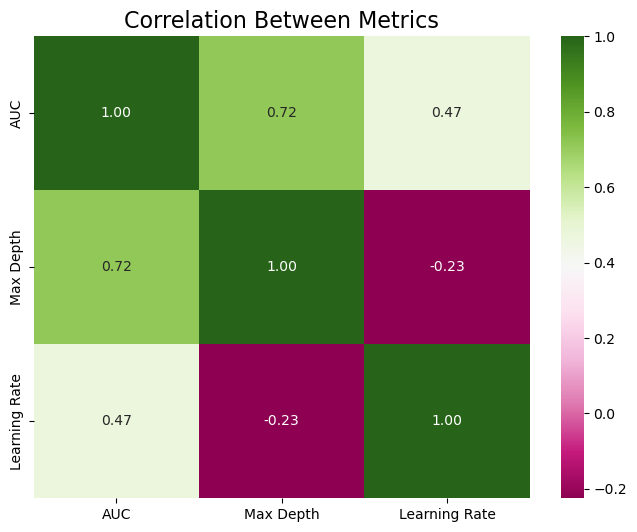

In [42]:
correlation_matrix = results3_df.drop(columns=["Run"]).corr()

plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap="PiYG", fmt=".2f")
plt.title("Correlation Between Metrics", fontsize=16)
plt.show()

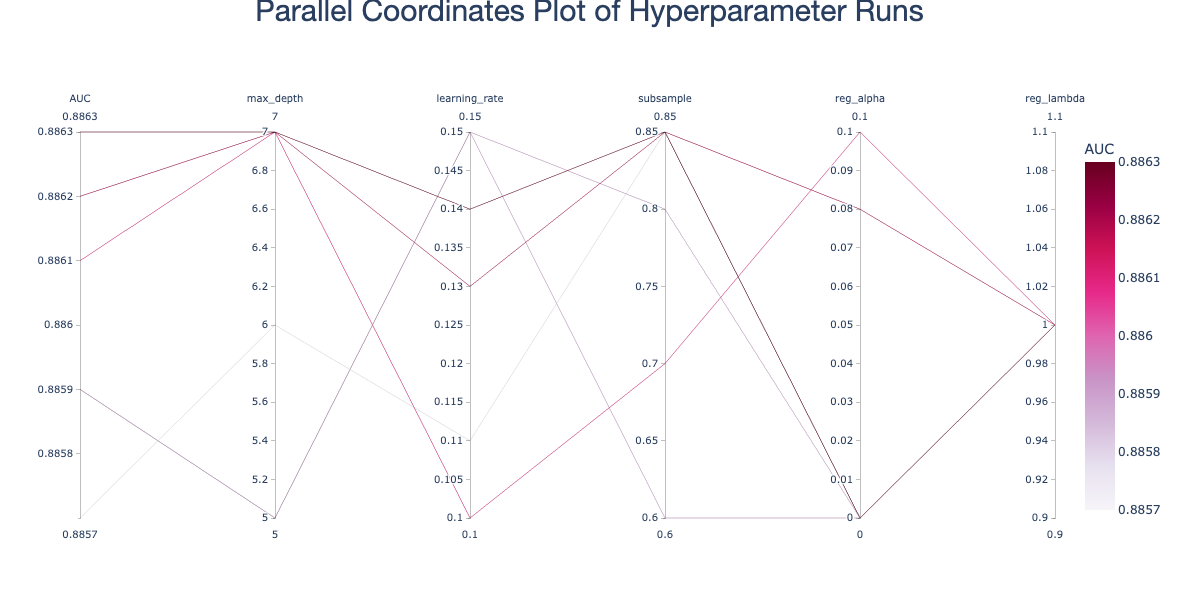

In [130]:
results_df = pd.DataFrame([
    {"Run": 1, "AUC": 0.8859, "max_depth": 5, "learning_rate": 0.15, "subsample": 0.8, "reg_alpha": 0, "reg_lambda": 1},
    {"Run": 2, "AUC": 0.8863, "max_depth": 7, "learning_rate": 0.14, "subsample": 0.85, "reg_alpha": 0, "reg_lambda": 1},
    {"Run": 3, "AUC": 0.8859, "max_depth": 5, "learning_rate": 0.15, "subsample": 0.6, "reg_alpha": 0, "reg_lambda": 1},
    {"Run": 4, "AUC": 0.8857, "max_depth": 6, "learning_rate": 0.11, "subsample": 0.85, "reg_alpha": 0, "reg_lambda": 1},
    {"Run": 5, "AUC": 0.8861, "max_depth": 7, "learning_rate": 0.1, "subsample": 0.7, "reg_alpha": 0.1, "reg_lambda": 1.0},
    {"Run": 6, "AUC": 0.8862, "max_depth": 7, "learning_rate": 0.13, "subsample": 0.85, "reg_alpha": 0.08, "reg_lambda": 1.0}
])

fig = px.parallel_coordinates(
    results_df,
    dimensions=["AUC", "max_depth", "learning_rate", "subsample", "reg_alpha", "reg_lambda"],
    color="AUC",
    color_continuous_scale=px.colors.sequential.PuRd,
    width=1400,
    height=600,
)


fig.update_layout(
    title=dict(text="Parallel Coordinates Plot of Hyperparameter Runs", font=dict(size=30)),
    title_font_family="Helvetica Neue",
    title_x=0.5,
    title_y=1.0,
    margin_t=130
)
fig.show()


<hr>

In [143]:
def train_baseline_model(X_train, y_train, X_val, y_val):
    dtrain = xgb.DMatrix(X_train, label=y_train)
    dval = xgb.DMatrix(X_val, label=y_val)

    # 'max_depth': 7, 'learning_rate': 0.13, 'subsample': 0.75}
    params = {
        "objective": "binary:logistic",
        "eval_metric": "auc",
        "max_depth": 7,
        "learning_rate": 0.05,
        "subsample": 0.85,
    }
    num_boost_round = 900

    bst = xgb.train(
        params,
        dtrain,
        num_boost_round=num_boost_round,
        evals=[(dtrain, "train"), (dval, "val")],
        early_stopping_rounds=50,
        verbose_eval=10, #show progress at every 10th iteration cycle
    )

    y_val_preds = bst.predict(dval)
    auc_val = roc_auc_score(y_val, y_val_preds)

    print(f"Validation AUC: {auc_val:.4f}")

    bst.save_model("baseline_model.json")
    print("Model saved as 'baseline_model.json'.")


In [144]:
train_baseline_model(X_train, y_train, X_test, y_test)

[0]	train-auc:0.87147	val-auc:0.87397
[10]	train-auc:0.87682	val-auc:0.87943
[20]	train-auc:0.87913	val-auc:0.88189
[30]	train-auc:0.88019	val-auc:0.88268
[40]	train-auc:0.88059	val-auc:0.88302
[50]	train-auc:0.88115	val-auc:0.88343
[60]	train-auc:0.88151	val-auc:0.88369
[70]	train-auc:0.88175	val-auc:0.88394
[80]	train-auc:0.88202	val-auc:0.88418
[90]	train-auc:0.88236	val-auc:0.88450
[100]	train-auc:0.88264	val-auc:0.88472
[110]	train-auc:0.88288	val-auc:0.88494
[120]	train-auc:0.88322	val-auc:0.88522
[130]	train-auc:0.88348	val-auc:0.88543
[140]	train-auc:0.88362	val-auc:0.88553
[150]	train-auc:0.88376	val-auc:0.88565
[160]	train-auc:0.88388	val-auc:0.88576
[170]	train-auc:0.88401	val-auc:0.88584
[180]	train-auc:0.88410	val-auc:0.88591
[190]	train-auc:0.88424	val-auc:0.88602
[200]	train-auc:0.88433	val-auc:0.88610
[210]	train-auc:0.88441	val-auc:0.88615
[220]	train-auc:0.88448	val-auc:0.88620
[230]	train-auc:0.88451	val-auc:0.88622
[240]	train-auc:0.88460	val-auc:0.88622
[250]	train

# Next Steps: Including more Parameters for more insights and a (maybe) better performance

##### 1. `colsample_bytree` and `colsample_bylevel`
These two parameters control the fraction of features that are randomly selected for each tree resp. each tree level. Adjusting these values can be helpful in mitigating cases of overfitting by introducing variability into the model.

```python
"colsample_bytree": {"min": 0.6, "max": 1.0},  # Features per tree
"colsample_bylevel": {"min": 0.6, "max": 1.0}  # Features per level
```

<br>
<div style="background-color: #F8AE29; text-align: left; width: 120%; height: 2px;"></div>
<br>

##### 2. `reg_alpha` and `reg_lambda`
These regularization parameters help manage overfitting by penalizing overly complex models.

```python
"reg_alpha": {"min": 0.0, "max": 0.1},  # L1 regularization
"reg_lambda": {"min": 0.5, "max": 1.5}  # L2 regularization
```

<br>
<div style="background-color: #F8AE29; text-align: left; width: 120%; height: 2px;"></div>
<br>

##### 3. `gamma`
The `gamma` parameter controls the sensitivity of the algorithm. It regulates the loss reduction when a leaf node is splitting. Higher values result in a more conservative model by limiting the creation of additional splits.

```python
"gamma": {"min": 0, "max": 5}
```

<br>
<div style="background-color: #F8AE29; text-align: left; width: 120%; height: 2px;"></div>
<br>

##### 4. `min_child_weight`
**min_child_weight** specifies the minimum sum of instance weights (like target values) required in a leaf node. It helps prevent overfitting by controlling how easily new splits are created.

```python
"min_child_weight": {"min": 1, "max": 10}
```


<br>
<div style="background-color: #F8AE29; text-align: left; width: 120%; height: 2px;"></div>
<br>

## Reasons for These Adjustments

- **Flexible Regularization** by tuning `reg_alpha` and `reg_lambda`, so that the model's capacity to generalize is improved, reducing the risk of overfitting.
- **Enhanced Subsampling Strategies** (like `colsample_bytree` and `colsample_bylevel`) enables the evaluation of diverse feature subsets, promoting model robustness.


In [145]:
X = combined_data.drop("income", axis=1)
y = combined_data["income"]

# (80% Train, 20% Test)
X_train_full, X_test, y_train_full, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# (80% Train, 20% Val out of 80%)
X_train, X_val, y_train, y_val = train_test_split(X_train_full, y_train_full, test_size=0.2, random_state=42)

print(f"Train: {X_train.shape}, Val: {X_val.shape}, Test: {X_test.shape}")


Train: (511999, 11), Val: (128000, 11), Test: (160000, 11)


In [146]:
print("Train income distribution:")
print(y_train.value_counts(normalize=True))

print("\nValidation income distribution:")
print(y_val.value_counts(normalize=True))

print("\nTest income distribution:")
print(y_test.value_counts(normalize=True))


Train income distribution:
income
0    0.751523
1    0.248477
Name: proportion, dtype: float64

Validation income distribution:
income
0    0.753883
1    0.246117
Name: proportion, dtype: float64

Test income distribution:
income
0    0.751594
1    0.248406
Name: proportion, dtype: float64


In [156]:
sweep_config = {
    "method": "bayes",
    "metric": {"goal": "maximize", "name": "Validation AUC"},
    "parameters": {
        "max_depth": {"min": 6, "max": 8},
        "learning_rate": {"min": 0.05, "max": 0.14},
        "n_estimators": {"min": 150, "max": 500},
        "subsample": {"min": 0.55, "max": 0.95},
        "colsample_bytree": {"min": 0.6, "max": 1.0},
        "colsample_bylevel": {"min": 0.6, "max": 1.0},
        "reg_alpha": {"min": 0.0, "max": 0.1}, # L1
        "reg_lambda": {"min": 0.5, "max": 1.5},  # L2
        "gamma": {"min": 0, "max": 5},
        "min_child_weight": {"min": 1, "max": 10}

    }
}

In [160]:
# New sweep configurationes based on the previous run
sweep_config2 = {
    "method": "bayes",
    "metric": {"goal": "maximize", "name": "Validation AUC"},
    "parameters": {
        "max_depth": {"values": [4, 5, 6, 7, 8]},
        "learning_rate": {"min": 0.05, "max": 0.14},
        "n_estimators": {"values": [100, 200, 300]},
        "subsample": {"min": 0.6, "max": 0.95},
        "reg_lambda": {"min": 0.5, "max": 2.0},
        "reg_alpha": {"min": 0.0, "max": 1.0},
        "min_child_weight": {"min": 1, "max": 10},
        "colsample_bytree": {"min": 0.5, "max": 1.0},
        "gamma": {"min": 0, "max": 5},
    }
}


In [164]:
# same old
sweep_config3 = {
    "method": "bayes",
    "metric": {"goal": "maximize", "name": "Validation AUC"},
    "parameters": {
        "max_depth": {"values": [6, 7, 8]}, 
        "learning_rate": {"min": 0.1, "max": 0.15},
        "n_estimators": {"values": [200, 300, 400]},
        "subsample": {"min": 0.75, "max": 0.95},
        "min_child_weight": {"min": 3, "max": 6},
        "colsample_bytree": {"min": 0.8, "max": 1.0},
        "gamma": {"min": 0, "max": 2},
        "reg_alpha": {"min": 0.5, "max": 1.0},
        "reg_lambda": {"min": 1.0, "max": 2.0}
    }
}


In [165]:
sweep_id = wandb.sweep(sweep_config3, project="fl-hyperparameter-sweep")

Create sweep with ID: u9e5hoch
Sweep URL: https://wandb.ai/laure-annina/fl-hyperparameter-sweep/sweeps/u9e5hoch


In [162]:
def train():
    wandb.init()
    config = wandb.config

    dtrain = xgb.DMatrix(X_train, label=y_train)
    dval = xgb.DMatrix(X_val, label=y_val)

    params = {
        "objective": "binary:logistic",
        "eval_metric": "auc",
        "max_depth": config.max_depth,
        "learning_rate": config.learning_rate,
        "subsample": config.subsample
    }

    bst = xgb.train(
        params,
        dtrain,
        num_boost_round=config.n_estimators,
        evals=[(dtrain, "train"), (dval, "val")],
        early_stopping_rounds=10,
        verbose_eval=0,
    )

    y_val_preds = bst.predict(dval)
    auc_val = roc_auc_score(y_val, y_val_preds)

    wandb.log({"Validation AUC": auc_val})

    bst.save_model(f"model_{wandb.run.name}.json")

    wandb.finish()

In [159]:
wandb.agent(sweep_id, function=train, count=20)

wandb: Agent Starting Run: 30e7mkpu with config:
wandb: 	colsample_bylevel: 0.779314761353779
wandb: 	colsample_bytree: 0.7520502674120564
wandb: 	gamma: 4
wandb: 	learning_rate: 0.12772178230631098
wandb: 	max_depth: 8
wandb: 	min_child_weight: 6
wandb: 	n_estimators: 189
wandb: 	reg_alpha: 0.03467152854262867
wandb: 	reg_lambda: 0.6990223251837124
wandb: 	subsample: 0.8507514955571086


Validation AUC,▁
Validation AUC,0.88349


wandb: Agent Starting Run: tamxe2w0 with config:
wandb: 	colsample_bylevel: 0.7265807994836129
wandb: 	colsample_bytree: 0.6589818667217199
wandb: 	gamma: 2
wandb: 	learning_rate: 0.05216282110495755
wandb: 	max_depth: 7
wandb: 	min_child_weight: 7
wandb: 	n_estimators: 334
wandb: 	reg_alpha: 0.012109572386651724
wandb: 	reg_lambda: 0.596476448139179
wandb: 	subsample: 0.652220646896502


Validation AUC,▁
Validation AUC,0.88343


wandb: Agent Starting Run: qf90o46x with config:
wandb: 	colsample_bylevel: 0.9764198380522672
wandb: 	colsample_bytree: 0.8376948138793164
wandb: 	gamma: 4
wandb: 	learning_rate: 0.0797513588759032
wandb: 	max_depth: 8
wandb: 	min_child_weight: 7
wandb: 	n_estimators: 357
wandb: 	reg_alpha: 0.06430017098877651
wandb: 	reg_lambda: 0.6532672747107933
wandb: 	subsample: 0.5621495825158234


Validation AUC,▁
Validation AUC,0.88354


wandb: Agent Starting Run: 96aofeiy with config:
wandb: 	colsample_bylevel: 0.8575571082700671
wandb: 	colsample_bytree: 0.8194693692291889
wandb: 	gamma: 1
wandb: 	learning_rate: 0.11304498119559736
wandb: 	max_depth: 6
wandb: 	min_child_weight: 2
wandb: 	n_estimators: 477
wandb: 	reg_alpha: 0.014624733600194829
wandb: 	reg_lambda: 0.645610744443182
wandb: 	subsample: 0.7767105481282908


Validation AUC,▁
Validation AUC,0.88364


wandb: Agent Starting Run: 3vaoo38l with config:
wandb: 	colsample_bylevel: 0.737158211716062
wandb: 	colsample_bytree: 0.994345887860185
wandb: 	gamma: 3
wandb: 	learning_rate: 0.11444229760262016
wandb: 	max_depth: 6
wandb: 	min_child_weight: 1
wandb: 	n_estimators: 264
wandb: 	reg_alpha: 0.03630462146492904
wandb: 	reg_lambda: 0.5573321307906923
wandb: 	subsample: 0.8083990861094896


Validation AUC,▁
Validation AUC,0.88357


wandb: Agent Starting Run: lhbcdb6y with config:
wandb: 	colsample_bylevel: 0.8486504063264634
wandb: 	colsample_bytree: 0.8196250248745862
wandb: 	gamma: 1
wandb: 	learning_rate: 0.12000280726007732
wandb: 	max_depth: 6
wandb: 	min_child_weight: 2
wandb: 	n_estimators: 473
wandb: 	reg_alpha: 0.014000305523743085
wandb: 	reg_lambda: 0.5506966874543724
wandb: 	subsample: 0.5902096776733803


Validation AUC,▁
Validation AUC,0.88357


wandb: Agent Starting Run: prnl7xhb with config:
wandb: 	colsample_bylevel: 0.811545180578199
wandb: 	colsample_bytree: 0.9529797443524464
wandb: 	gamma: 1
wandb: 	learning_rate: 0.11794583211266724
wandb: 	max_depth: 7
wandb: 	min_child_weight: 3
wandb: 	n_estimators: 447
wandb: 	reg_alpha: 0.012536893655936278
wandb: 	reg_lambda: 0.6150128926371338
wandb: 	subsample: 0.7999861755489472


Validation AUC,▁
Validation AUC,0.88347


wandb: Agent Starting Run: cve03d77 with config:
wandb: 	colsample_bylevel: 0.8833075549357314
wandb: 	colsample_bytree: 0.8012189846227753
wandb: 	gamma: 1
wandb: 	learning_rate: 0.08853321904495555
wandb: 	max_depth: 6
wandb: 	min_child_weight: 3
wandb: 	n_estimators: 462
wandb: 	reg_alpha: 0.013865938705156412
wandb: 	reg_lambda: 0.7182260280566235
wandb: 	subsample: 0.8302878791396662


Validation AUC,▁
Validation AUC,0.88355


wandb: Agent Starting Run: u85i8koz with config:
wandb: 	colsample_bylevel: 0.8277289190903377
wandb: 	colsample_bytree: 0.7564886123355836
wandb: 	gamma: 1
wandb: 	learning_rate: 0.10020133287371294
wandb: 	max_depth: 7
wandb: 	min_child_weight: 2
wandb: 	n_estimators: 404
wandb: 	reg_alpha: 0.02756359074691075
wandb: 	reg_lambda: 0.8885604292215946
wandb: 	subsample: 0.7937246787231697


Validation AUC,▁
Validation AUC,0.88357


wandb: Agent Starting Run: u7enkqkg with config:
wandb: 	colsample_bylevel: 0.9022813183355464
wandb: 	colsample_bytree: 0.7163904242796281
wandb: 	gamma: 2
wandb: 	learning_rate: 0.12851996490459475
wandb: 	max_depth: 7
wandb: 	min_child_weight: 2
wandb: 	n_estimators: 499
wandb: 	reg_alpha: 0.007244087172994008
wandb: 	reg_lambda: 0.5125886380653399
wandb: 	subsample: 0.7894709949888808


Validation AUC,▁
Validation AUC,0.88339


wandb: Agent Starting Run: o2vcghvy with config:
wandb: 	colsample_bylevel: 0.8199283997232242
wandb: 	colsample_bytree: 0.8638740452760687
wandb: 	gamma: 2
wandb: 	learning_rate: 0.12804963967070915
wandb: 	max_depth: 7
wandb: 	min_child_weight: 2
wandb: 	n_estimators: 484
wandb: 	reg_alpha: 0.0035334509664531224
wandb: 	reg_lambda: 0.6044646269517171
wandb: 	subsample: 0.6724611275341957


Validation AUC,▁
Validation AUC,0.88355


wandb: Agent Starting Run: iy4zvlzp with config:
wandb: 	colsample_bylevel: 0.9239094473379804
wandb: 	colsample_bytree: 0.7495407177468545
wandb: 	gamma: 2
wandb: 	learning_rate: 0.12020228626330666
wandb: 	max_depth: 6
wandb: 	min_child_weight: 3
wandb: 	n_estimators: 416
wandb: 	reg_alpha: 0.03109888110112661
wandb: 	reg_lambda: 0.8771453855424749
wandb: 	subsample: 0.7181173476233855


Validation AUC,▁
Validation AUC,0.88333


wandb: Agent Starting Run: bkqmh696 with config:
wandb: 	colsample_bylevel: 0.7721972123004115
wandb: 	colsample_bytree: 0.9585543201850188
wandb: 	gamma: 4
wandb: 	learning_rate: 0.11895202208632762
wandb: 	max_depth: 6
wandb: 	min_child_weight: 1
wandb: 	n_estimators: 253
wandb: 	reg_alpha: 0.03119567135327513
wandb: 	reg_lambda: 0.7116920172093573
wandb: 	subsample: 0.8102558023210595


Validation AUC,▁
Validation AUC,0.8836


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: ac0l9bdw with config:
wandb: 	colsample_bylevel: 0.925029559248963
wandb: 	colsample_bytree: 0.761077999126092
wandb: 	gamma: 1
wandb: 	learning_rate: 0.07137820691509565
wandb: 	max_depth: 6
wandb: 	min_child_weight: 3
wandb: 	n_estimators: 436
wandb: 	reg_alpha: 0.0032190221704061052
wandb: 	reg_lambda: 0.579761676836165
wandb: 	subsample: 0.9193666080892404


Validation AUC,▁
Validation AUC,0.8836


wandb: Agent Starting Run: fd2ovagi with config:
wandb: 	colsample_bylevel: 0.869674707969468
wandb: 	colsample_bytree: 0.8042780921482613
wandb: 	gamma: 1
wandb: 	learning_rate: 0.11404602598919068
wandb: 	max_depth: 7
wandb: 	min_child_weight: 3
wandb: 	n_estimators: 457
wandb: 	reg_alpha: 0.03399813031831407
wandb: 	reg_lambda: 0.5347059261500321
wandb: 	subsample: 0.6881296227402653


Validation AUC,▁
Validation AUC,0.88345


wandb: Agent Starting Run: ctlxgux9 with config:
wandb: 	colsample_bylevel: 0.7599611994202818
wandb: 	colsample_bytree: 0.9738222065192752
wandb: 	gamma: 4
wandb: 	learning_rate: 0.11079535464207602
wandb: 	max_depth: 6
wandb: 	min_child_weight: 2
wandb: 	n_estimators: 310
wandb: 	reg_alpha: 0.026939676506919332
wandb: 	reg_lambda: 0.68828992866162
wandb: 	subsample: 0.8909831748944684


Validation AUC,▁
Validation AUC,0.88361


wandb: Agent Starting Run: 5qgmctiu with config:
wandb: 	colsample_bylevel: 0.6587776844530734
wandb: 	colsample_bytree: 0.9980011703643268
wandb: 	gamma: 3
wandb: 	learning_rate: 0.09025055166002666
wandb: 	max_depth: 7
wandb: 	min_child_weight: 2
wandb: 	n_estimators: 341
wandb: 	reg_alpha: 0.03358136544380376
wandb: 	reg_lambda: 0.515354906405345
wandb: 	subsample: 0.8625424128406277


Validation AUC,▁
Validation AUC,0.88352


wandb: Agent Starting Run: jxccw2vb with config:
wandb: 	colsample_bylevel: 0.8442120068014136
wandb: 	colsample_bytree: 0.8974604015190614
wandb: 	gamma: 4
wandb: 	learning_rate: 0.10993389006171078
wandb: 	max_depth: 7
wandb: 	min_child_weight: 1
wandb: 	n_estimators: 375
wandb: 	reg_alpha: 0.007660356429708893
wandb: 	reg_lambda: 0.6131980690774705
wandb: 	subsample: 0.8236686752651741


Validation AUC,▁
Validation AUC,0.88359


wandb: Agent Starting Run: 5no9hwpr with config:
wandb: 	colsample_bylevel: 0.8165805691842069
wandb: 	colsample_bytree: 0.9309349044876812
wandb: 	gamma: 3
wandb: 	learning_rate: 0.131439734797583
wandb: 	max_depth: 7
wandb: 	min_child_weight: 2
wandb: 	n_estimators: 230
wandb: 	reg_alpha: 0.03747798346270459
wandb: 	reg_lambda: 0.6078977713820434
wandb: 	subsample: 0.8389217035551872


Validation AUC,▁
Validation AUC,0.88355


wandb: Agent Starting Run: ytbw7z3m with config:
wandb: 	colsample_bylevel: 0.8630892884017418
wandb: 	colsample_bytree: 0.93471410252572
wandb: 	gamma: 4
wandb: 	learning_rate: 0.10614512108597406
wandb: 	max_depth: 7
wandb: 	min_child_weight: 5
wandb: 	n_estimators: 306
wandb: 	reg_alpha: 0.025243773545156535
wandb: 	reg_lambda: 0.7672398130490915
wandb: 	subsample: 0.8793757198337768


Validation AUC,▁
Validation AUC,0.88356


In [163]:
wandb.agent(sweep_id, function=train, count=20)

wandb: Agent Starting Run: ujuh65zg with config:
wandb: 	colsample_bytree: 0.5593251260757828
wandb: 	gamma: 2
wandb: 	learning_rate: 0.06661182378868322
wandb: 	max_depth: 6
wandb: 	min_child_weight: 10
wandb: 	n_estimators: 100
wandb: 	reg_alpha: 0.36342287729512
wandb: 	reg_lambda: 0.977960413303914
wandb: 	subsample: 0.6863917297472926


Validation AUC,▁
Validation AUC,0.88208


wandb: Agent Starting Run: 5w8v16pr with config:
wandb: 	colsample_bytree: 0.8112035632944319
wandb: 	gamma: 2
wandb: 	learning_rate: 0.06829929089723229
wandb: 	max_depth: 6
wandb: 	min_child_weight: 10
wandb: 	n_estimators: 200
wandb: 	reg_alpha: 0.4804182154975304
wandb: 	reg_lambda: 0.973123555166241
wandb: 	subsample: 0.7096855750796093


Validation AUC,▁
Validation AUC,0.88335


wandb: Agent Starting Run: gp44c78d with config:
wandb: 	colsample_bytree: 0.5130206544273362
wandb: 	gamma: 0
wandb: 	learning_rate: 0.112108555814038
wandb: 	max_depth: 5
wandb: 	min_child_weight: 3
wandb: 	n_estimators: 300
wandb: 	reg_alpha: 0.8197390593637922
wandb: 	reg_lambda: 0.8963426877902686
wandb: 	subsample: 0.8919934272051417


Validation AUC,▁
Validation AUC,0.88356


wandb: Agent Starting Run: frca5n0p with config:
wandb: 	colsample_bytree: 0.8686556254329612
wandb: 	gamma: 2
wandb: 	learning_rate: 0.07840510447016692
wandb: 	max_depth: 6
wandb: 	min_child_weight: 8
wandb: 	n_estimators: 200
wandb: 	reg_alpha: 0.28991462801950574
wandb: 	reg_lambda: 0.7944430586481794
wandb: 	subsample: 0.7385815160116643


Validation AUC,▁
Validation AUC,0.88348


wandb: Agent Starting Run: ccq6ye86 with config:
wandb: 	colsample_bytree: 0.936255348147328
wandb: 	gamma: 4
wandb: 	learning_rate: 0.05740952419808343
wandb: 	max_depth: 7
wandb: 	min_child_weight: 8
wandb: 	n_estimators: 200
wandb: 	reg_alpha: 0.16985480713593326
wandb: 	reg_lambda: 0.7859828915138125
wandb: 	subsample: 0.7603819050368148


Validation AUC,▁
Validation AUC,0.88336


wandb: Agent Starting Run: pxo7bv8a with config:
wandb: 	colsample_bytree: 0.8863498304843234
wandb: 	gamma: 4
wandb: 	learning_rate: 0.07177375741062747
wandb: 	max_depth: 5
wandb: 	min_child_weight: 9
wandb: 	n_estimators: 200
wandb: 	reg_alpha: 0.38146740527443634
wandb: 	reg_lambda: 0.5578095819863789
wandb: 	subsample: 0.7807205798803618


Validation AUC,▁
Validation AUC,0.88297


wandb: Agent Starting Run: k67ox7y0 with config:
wandb: 	colsample_bytree: 0.6076069705781253
wandb: 	gamma: 1
wandb: 	learning_rate: 0.09004152209858496
wandb: 	max_depth: 5
wandb: 	min_child_weight: 5
wandb: 	n_estimators: 300
wandb: 	reg_alpha: 0.6792753004960667
wandb: 	reg_lambda: 0.9253842393655844
wandb: 	subsample: 0.9276595577654864


Validation AUC,▁
Validation AUC,0.88358


wandb: Agent Starting Run: sg7ghknq with config:
wandb: 	colsample_bytree: 0.572225534857921
wandb: 	gamma: 0
wandb: 	learning_rate: 0.08855039157884777
wandb: 	max_depth: 4
wandb: 	min_child_weight: 5
wandb: 	n_estimators: 300
wandb: 	reg_alpha: 0.734803970511799
wandb: 	reg_lambda: 0.6822570592062316
wandb: 	subsample: 0.937561339317068


Validation AUC,▁
Validation AUC,0.88325


wandb: Agent Starting Run: dap1vkeq with config:
wandb: 	colsample_bytree: 0.6402219676415619
wandb: 	gamma: 1
wandb: 	learning_rate: 0.118532256498603
wandb: 	max_depth: 5
wandb: 	min_child_weight: 7
wandb: 	n_estimators: 300
wandb: 	reg_alpha: 0.7099869326014221
wandb: 	reg_lambda: 1.3144587805028212
wandb: 	subsample: 0.9112910624563582


Validation AUC,▁
Validation AUC,0.88356


wandb: Agent Starting Run: rw3t60n0 with config:
wandb: 	colsample_bytree: 0.6791745885403988
wandb: 	gamma: 2
wandb: 	learning_rate: 0.11219366244049096
wandb: 	max_depth: 7
wandb: 	min_child_weight: 6
wandb: 	n_estimators: 300
wandb: 	reg_alpha: 0.7297772204806958
wandb: 	reg_lambda: 1.2764038347303006
wandb: 	subsample: 0.8560337251390926


Validation AUC,▁
Validation AUC,0.88353


wandb: Agent Starting Run: 3bnikrki with config:
wandb: 	colsample_bytree: 0.8262054302103359
wandb: 	gamma: 2
wandb: 	learning_rate: 0.09776479348181336
wandb: 	max_depth: 6
wandb: 	min_child_weight: 4
wandb: 	n_estimators: 300
wandb: 	reg_alpha: 0.7398675938273422
wandb: 	reg_lambda: 1.4362955544517235
wandb: 	subsample: 0.8452424551578963


Validation AUC,▁
Validation AUC,0.88358


wandb: Agent Starting Run: i7nryqm3 with config:
wandb: 	colsample_bytree: 0.561977729542694
wandb: 	gamma: 3
wandb: 	learning_rate: 0.13173884802697816
wandb: 	max_depth: 7
wandb: 	min_child_weight: 2
wandb: 	n_estimators: 300
wandb: 	reg_alpha: 0.7142261038670534
wandb: 	reg_lambda: 1.1996426423890338
wandb: 	subsample: 0.8962985299468198


Validation AUC,▁
Validation AUC,0.8836


wandb: Agent Starting Run: rdporv5l with config:
wandb: 	colsample_bytree: 0.9327649618207688
wandb: 	gamma: 2
wandb: 	learning_rate: 0.0986769917191768
wandb: 	max_depth: 7
wandb: 	min_child_weight: 8
wandb: 	n_estimators: 300
wandb: 	reg_alpha: 0.4911262563730163
wandb: 	reg_lambda: 1.018476261333479
wandb: 	subsample: 0.7250034664090566


Validation AUC,▁
Validation AUC,0.88355


wandb: Agent Starting Run: 35gtc2c7 with config:
wandb: 	colsample_bytree: 0.8873980917078388
wandb: 	gamma: 1
wandb: 	learning_rate: 0.07935284063212575
wandb: 	max_depth: 7
wandb: 	min_child_weight: 8
wandb: 	n_estimators: 300
wandb: 	reg_alpha: 0.35663958932026796
wandb: 	reg_lambda: 1.3187806636177704
wandb: 	subsample: 0.7694904190190563


Validation AUC,▁
Validation AUC,0.88351


wandb: Agent Starting Run: 3qsxwir9 with config:
wandb: 	colsample_bytree: 0.757910831593713
wandb: 	gamma: 2
wandb: 	learning_rate: 0.10234500040055072
wandb: 	max_depth: 7
wandb: 	min_child_weight: 2
wandb: 	n_estimators: 300
wandb: 	reg_alpha: 0.8116141041782442
wandb: 	reg_lambda: 1.3601819947619134
wandb: 	subsample: 0.8957561558638337


Validation AUC,▁
Validation AUC,0.8836


wandb: Agent Starting Run: exfjmoyo with config:
wandb: 	colsample_bytree: 0.9009925537149602
wandb: 	gamma: 0
wandb: 	learning_rate: 0.123047460320119
wandb: 	max_depth: 7
wandb: 	min_child_weight: 3
wandb: 	n_estimators: 300
wandb: 	reg_alpha: 0.874103805414522
wandb: 	reg_lambda: 1.3296649668523033
wandb: 	subsample: 0.8881906692324321


Validation AUC,▁
Validation AUC,0.88352


wandb: Agent Starting Run: cjbu0vgx with config:
wandb: 	colsample_bytree: 0.8945405334489046
wandb: 	gamma: 0
wandb: 	learning_rate: 0.11756348565357728
wandb: 	max_depth: 8
wandb: 	min_child_weight: 1
wandb: 	n_estimators: 300
wandb: 	reg_alpha: 0.3104734424621427
wandb: 	reg_lambda: 0.8653715317207508
wandb: 	subsample: 0.8992526342902196


Validation AUC,▁
Validation AUC,0.8835


wandb: Agent Starting Run: ejo0ph0z with config:
wandb: 	colsample_bytree: 0.5921444523166233
wandb: 	gamma: 1
wandb: 	learning_rate: 0.13470877694800243
wandb: 	max_depth: 8
wandb: 	min_child_weight: 1
wandb: 	n_estimators: 300
wandb: 	reg_alpha: 0.9079487224221529
wandb: 	reg_lambda: 1.498488776772677
wandb: 	subsample: 0.9319091344841126


Validation AUC,▁
Validation AUC,0.88348


wandb: Agent Starting Run: oeb1s83x with config:
wandb: 	colsample_bytree: 0.7621577184030234
wandb: 	gamma: 1
wandb: 	learning_rate: 0.12508242459837035
wandb: 	max_depth: 6
wandb: 	min_child_weight: 2
wandb: 	n_estimators: 300
wandb: 	reg_alpha: 0.723967958458799
wandb: 	reg_lambda: 0.9566129215051652
wandb: 	subsample: 0.938557182049892


Validation AUC,▁
Validation AUC,0.88361


wandb: Agent Starting Run: u8srwsbs with config:
wandb: 	colsample_bytree: 0.7396929296986834
wandb: 	gamma: 3
wandb: 	learning_rate: 0.11303948752799292
wandb: 	max_depth: 4
wandb: 	min_child_weight: 1
wandb: 	n_estimators: 300
wandb: 	reg_alpha: 0.4914433918126233
wandb: 	reg_lambda: 1.3841293760208
wandb: 	subsample: 0.8864542399261979


Validation AUC,▁
Validation AUC,0.87592


In [166]:
wandb.agent(sweep_id, function=train, count=50)

wandb: Agent Starting Run: k6pj00yz with config:
wandb: 	colsample_bytree: 0.9846557810356438
wandb: 	gamma: 2
wandb: 	learning_rate: 0.13823610230602956
wandb: 	max_depth: 8
wandb: 	min_child_weight: 3
wandb: 	n_estimators: 200
wandb: 	reg_alpha: 0.697369597354728
wandb: 	reg_lambda: 1.8644432103787292
wandb: 	subsample: 0.827667772363379


Validation AUC,▁
Validation AUC,0.8835


wandb: Agent Starting Run: 0s1h1szf with config:
wandb: 	colsample_bytree: 0.9895012003322624
wandb: 	gamma: 1
wandb: 	learning_rate: 0.14510321024702558
wandb: 	max_depth: 7
wandb: 	min_child_weight: 6
wandb: 	n_estimators: 200
wandb: 	reg_alpha: 0.6909726611828306
wandb: 	reg_lambda: 1.517239188679648
wandb: 	subsample: 0.8960695001291585


Validation AUC,▁
Validation AUC,0.88353


wandb: Agent Starting Run: w7jy6o9t with config:
wandb: 	colsample_bytree: 0.9468398225195386
wandb: 	gamma: 2
wandb: 	learning_rate: 0.12490325414760314
wandb: 	max_depth: 6
wandb: 	min_child_weight: 5
wandb: 	n_estimators: 200
wandb: 	reg_alpha: 0.9446149784654796
wandb: 	reg_lambda: 1.5996511982409074
wandb: 	subsample: 0.8204461560125222


Validation AUC,▁
Validation AUC,0.88364


wandb: Agent Starting Run: vg4ri7z5 with config:
wandb: 	colsample_bytree: 0.8677401656332571
wandb: 	gamma: 1
wandb: 	learning_rate: 0.1339320150610459
wandb: 	max_depth: 6
wandb: 	min_child_weight: 6
wandb: 	n_estimators: 400
wandb: 	reg_alpha: 0.8845708059114856
wandb: 	reg_lambda: 1.6912697596771329
wandb: 	subsample: 0.7551518707840741


Validation AUC,▁
Validation AUC,0.8836


wandb: Agent Starting Run: drh5mfa3 with config:
wandb: 	colsample_bytree: 0.9889769656616888
wandb: 	gamma: 2
wandb: 	learning_rate: 0.12644309974243084
wandb: 	max_depth: 6
wandb: 	min_child_weight: 6
wandb: 	n_estimators: 300
wandb: 	reg_alpha: 0.9401870621549973
wandb: 	reg_lambda: 1.583523100966655
wandb: 	subsample: 0.8373511898790198


Validation AUC,▁
Validation AUC,0.88356


wandb: Agent Starting Run: 1z5zbtbd with config:
wandb: 	colsample_bytree: 0.9043361925900516
wandb: 	gamma: 2
wandb: 	learning_rate: 0.10153552933303
wandb: 	max_depth: 6
wandb: 	min_child_weight: 5
wandb: 	n_estimators: 200
wandb: 	reg_alpha: 0.761985789215753
wandb: 	reg_lambda: 1.734573051382486
wandb: 	subsample: 0.8209622447735971


Validation AUC,▁
Validation AUC,0.88348


wandb: Agent Starting Run: 3z636p3z with config:
wandb: 	colsample_bytree: 0.9471525129242192
wandb: 	gamma: 2
wandb: 	learning_rate: 0.13082110706716463
wandb: 	max_depth: 6
wandb: 	min_child_weight: 6
wandb: 	n_estimators: 200
wandb: 	reg_alpha: 0.9176652660637172
wandb: 	reg_lambda: 1.7110056512773224
wandb: 	subsample: 0.8753488245103356


Validation AUC,▁
Validation AUC,0.88358


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 94qtat1g with config:
wandb: 	colsample_bytree: 0.955978354148276
wandb: 	gamma: 2
wandb: 	learning_rate: 0.13760907444972842
wandb: 	max_depth: 7
wandb: 	min_child_weight: 5
wandb: 	n_estimators: 200
wandb: 	reg_alpha: 0.9183168412358608
wandb: 	reg_lambda: 1.6724047251700682
wandb: 	subsample: 0.7765595933215466


Validation AUC,▁
Validation AUC,0.88352


wandb: Agent Starting Run: lpqdvzjr with config:
wandb: 	colsample_bytree: 0.9363499828911648
wandb: 	gamma: 2
wandb: 	learning_rate: 0.1288329942424989
wandb: 	max_depth: 6
wandb: 	min_child_weight: 6
wandb: 	n_estimators: 200
wandb: 	reg_alpha: 0.9024955906801492
wandb: 	reg_lambda: 1.5372130108177031
wandb: 	subsample: 0.8480463512974762


Validation AUC,▁
Validation AUC,0.88363


wandb: Agent Starting Run: 49atcecd with config:
wandb: 	colsample_bytree: 0.9187931926568592
wandb: 	gamma: 2
wandb: 	learning_rate: 0.140057342625017
wandb: 	max_depth: 7
wandb: 	min_child_weight: 5
wandb: 	n_estimators: 200
wandb: 	reg_alpha: 0.9322644608947854
wandb: 	reg_lambda: 1.462667583019979
wandb: 	subsample: 0.876981131220244


Validation AUC,▁
Validation AUC,0.88358


wandb: Agent Starting Run: 6xhya4xw with config:
wandb: 	colsample_bytree: 0.8866997514698379
wandb: 	gamma: 2
wandb: 	learning_rate: 0.12993381895591005
wandb: 	max_depth: 6
wandb: 	min_child_weight: 5
wandb: 	n_estimators: 200
wandb: 	reg_alpha: 0.8407001144672122
wandb: 	reg_lambda: 1.5557592633758128
wandb: 	subsample: 0.8330115390907973


Validation AUC,▁
Validation AUC,0.8834


wandb: Agent Starting Run: huhpifcr with config:
wandb: 	colsample_bytree: 0.9393794724093162
wandb: 	gamma: 2
wandb: 	learning_rate: 0.11203848392045528
wandb: 	max_depth: 6
wandb: 	min_child_weight: 6
wandb: 	n_estimators: 300
wandb: 	reg_alpha: 0.970293389348368
wandb: 	reg_lambda: 1.625400081917201
wandb: 	subsample: 0.8418938105458086


Validation AUC,▁
Validation AUC,0.88358


wandb: Agent Starting Run: 9aayx0yr with config:
wandb: 	colsample_bytree: 0.9056870344556648
wandb: 	gamma: 2
wandb: 	learning_rate: 0.14256736483301824
wandb: 	max_depth: 6
wandb: 	min_child_weight: 6
wandb: 	n_estimators: 200
wandb: 	reg_alpha: 0.9451740016112044
wandb: 	reg_lambda: 1.438360874791008
wandb: 	subsample: 0.8736121874805032


Validation AUC,▁
Validation AUC,0.88359


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 8powf76n with config:
wandb: 	colsample_bytree: 0.9753106669901526
wandb: 	gamma: 2
wandb: 	learning_rate: 0.12659113308793643
wandb: 	max_depth: 7
wandb: 	min_child_weight: 6
wandb: 	n_estimators: 200
wandb: 	reg_alpha: 0.9177999784200618
wandb: 	reg_lambda: 1.7662761250230608
wandb: 	subsample: 0.8845269093147046


Validation AUC,▁
Validation AUC,0.88355


wandb: Agent Starting Run: nj7hon5g with config:
wandb: 	colsample_bytree: 0.9570133119374123
wandb: 	gamma: 2
wandb: 	learning_rate: 0.12284734617670658
wandb: 	max_depth: 6
wandb: 	min_child_weight: 6
wandb: 	n_estimators: 300
wandb: 	reg_alpha: 0.9210121375734592
wandb: 	reg_lambda: 1.4313785584262138
wandb: 	subsample: 0.7827554356827584


Validation AUC,▁
Validation AUC,0.88357


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: pq9zoufl with config:
wandb: 	colsample_bytree: 0.9464324119069876
wandb: 	gamma: 2
wandb: 	learning_rate: 0.13230593890455267
wandb: 	max_depth: 7
wandb: 	min_child_weight: 5
wandb: 	n_estimators: 200
wandb: 	reg_alpha: 0.864441729435963
wandb: 	reg_lambda: 1.4868443485817942
wandb: 	subsample: 0.8556919611835627


Validation AUC,▁
Validation AUC,0.8835


wandb: Agent Starting Run: 38fu50qd with config:
wandb: 	colsample_bytree: 0.9597214527628184
wandb: 	gamma: 2
wandb: 	learning_rate: 0.1384925417882124
wandb: 	max_depth: 7
wandb: 	min_child_weight: 6
wandb: 	n_estimators: 200
wandb: 	reg_alpha: 0.8636794083230216
wandb: 	reg_lambda: 1.5538849658806382
wandb: 	subsample: 0.8395277213947331


Validation AUC,▁
Validation AUC,0.88352


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: bb7u3cpq with config:
wandb: 	colsample_bytree: 0.9622970589174484
wandb: 	gamma: 2
wandb: 	learning_rate: 0.12265325714844023
wandb: 	max_depth: 6
wandb: 	min_child_weight: 5
wandb: 	n_estimators: 200
wandb: 	reg_alpha: 0.8692603240785306
wandb: 	reg_lambda: 1.6652208932835053
wandb: 	subsample: 0.7750037105683992


Validation AUC,▁
Validation AUC,0.8836


wandb: Agent Starting Run: 41ta1b3m with config:
wandb: 	colsample_bytree: 0.9289082294471794
wandb: 	gamma: 2
wandb: 	learning_rate: 0.13172370292381566
wandb: 	max_depth: 6
wandb: 	min_child_weight: 6
wandb: 	n_estimators: 300
wandb: 	reg_alpha: 0.9387475144572408
wandb: 	reg_lambda: 1.7166280656777304
wandb: 	subsample: 0.8043691108753955


Validation AUC,▁
Validation AUC,0.88344


wandb: Agent Starting Run: rnvaq3y8 with config:
wandb: 	colsample_bytree: 0.8761832775523715
wandb: 	gamma: 2
wandb: 	learning_rate: 0.10633073450347157
wandb: 	max_depth: 6
wandb: 	min_child_weight: 4
wandb: 	n_estimators: 300
wandb: 	reg_alpha: 0.6432049837547511
wandb: 	reg_lambda: 1.5616868002117492
wandb: 	subsample: 0.7579231771925007


Validation AUC,▁
Validation AUC,0.88353


wandb: Agent Starting Run: ifk0uklw with config:
wandb: 	colsample_bytree: 0.817217780319366
wandb: 	gamma: 1
wandb: 	learning_rate: 0.13628321888381
wandb: 	max_depth: 8
wandb: 	min_child_weight: 6
wandb: 	n_estimators: 400
wandb: 	reg_alpha: 0.6879031441284675
wandb: 	reg_lambda: 1.3738721635208244
wandb: 	subsample: 0.9194682860318976


Validation AUC,▁
Validation AUC,0.8835


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 6fls0p9f with config:
wandb: 	colsample_bytree: 0.8175206423949193
wandb: 	gamma: 1
wandb: 	learning_rate: 0.10786624912570655
wandb: 	max_depth: 8
wandb: 	min_child_weight: 3
wandb: 	n_estimators: 400
wandb: 	reg_alpha: 0.6522170324326966
wandb: 	reg_lambda: 1.3960771256809923
wandb: 	subsample: 0.8186947146375183


Validation AUC,▁
Validation AUC,0.88349


wandb: Agent Starting Run: qbf3ujah with config:
wandb: 	colsample_bytree: 0.8646851989829447
wandb: 	gamma: 2
wandb: 	learning_rate: 0.10346763163067754
wandb: 	max_depth: 7
wandb: 	min_child_weight: 3
wandb: 	n_estimators: 200
wandb: 	reg_alpha: 0.8969246707931475
wandb: 	reg_lambda: 1.7995224145706137
wandb: 	subsample: 0.7586646200976143


Validation AUC,▁
Validation AUC,0.8835


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: fh5zimp9 with config:
wandb: 	colsample_bytree: 0.8333496797486319
wandb: 	gamma: 1
wandb: 	learning_rate: 0.13356205679129984
wandb: 	max_depth: 6
wandb: 	min_child_weight: 6
wandb: 	n_estimators: 300
wandb: 	reg_alpha: 0.8294352469103347
wandb: 	reg_lambda: 1.8390879791521484
wandb: 	subsample: 0.9192321593740888


Validation AUC,▁
Validation AUC,0.88361


wandb: Agent Starting Run: ztle6q5b with config:
wandb: 	colsample_bytree: 0.9487281127303748
wandb: 	gamma: 2
wandb: 	learning_rate: 0.10188431406996716
wandb: 	max_depth: 7
wandb: 	min_child_weight: 6
wandb: 	n_estimators: 300
wandb: 	reg_alpha: 0.6396026405560968
wandb: 	reg_lambda: 1.8092666840295588
wandb: 	subsample: 0.8385473842739665


Validation AUC,▁
Validation AUC,0.88353


wandb: Agent Starting Run: gcnabnul with config:
wandb: 	colsample_bytree: 0.9112553214969142
wandb: 	gamma: 0
wandb: 	learning_rate: 0.12639320115464403
wandb: 	max_depth: 8
wandb: 	min_child_weight: 4
wandb: 	n_estimators: 300
wandb: 	reg_alpha: 0.926651681564455
wandb: 	reg_lambda: 1.2849798334344174
wandb: 	subsample: 0.8397006043436325


Validation AUC,▁
Validation AUC,0.8835


wandb: Agent Starting Run: 41j25az3 with config:
wandb: 	colsample_bytree: 0.9370327293051268
wandb: 	gamma: 0
wandb: 	learning_rate: 0.14281507570445115
wandb: 	max_depth: 8
wandb: 	min_child_weight: 5
wandb: 	n_estimators: 400
wandb: 	reg_alpha: 0.8575957421134659
wandb: 	reg_lambda: 1.0723061921477064
wandb: 	subsample: 0.8754815980878239


Validation AUC,▁
Validation AUC,0.88344


wandb: Agent Starting Run: xji5x35u with config:
wandb: 	colsample_bytree: 0.9629935631279074
wandb: 	gamma: 2
wandb: 	learning_rate: 0.13239286994573693
wandb: 	max_depth: 7
wandb: 	min_child_weight: 6
wandb: 	n_estimators: 300
wandb: 	reg_alpha: 0.8098366086880261
wandb: 	reg_lambda: 1.7470191074900776
wandb: 	subsample: 0.8964644165911884


Validation AUC,▁
Validation AUC,0.88359


wandb: Agent Starting Run: t834w3mz with config:
wandb: 	colsample_bytree: 0.953910535403799
wandb: 	gamma: 2
wandb: 	learning_rate: 0.11771252905904658
wandb: 	max_depth: 6
wandb: 	min_child_weight: 5
wandb: 	n_estimators: 200
wandb: 	reg_alpha: 0.8199349785027112
wandb: 	reg_lambda: 1.698632609645137
wandb: 	subsample: 0.7805955192686631


Validation AUC,▁
Validation AUC,0.88352


wandb: Agent Starting Run: 2m0ykqr8 with config:
wandb: 	colsample_bytree: 0.8475181808952924
wandb: 	gamma: 0
wandb: 	learning_rate: 0.1373492588398827
wandb: 	max_depth: 7
wandb: 	min_child_weight: 6
wandb: 	n_estimators: 400
wandb: 	reg_alpha: 0.89850866465201
wandb: 	reg_lambda: 1.887610849417987
wandb: 	subsample: 0.8445478487653919


Validation AUC,▁
Validation AUC,0.88349


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: xb4f7j5b with config:
wandb: 	colsample_bytree: 0.8971111752095703
wandb: 	gamma: 0
wandb: 	learning_rate: 0.12153633085012032
wandb: 	max_depth: 8
wandb: 	min_child_weight: 6
wandb: 	n_estimators: 200
wandb: 	reg_alpha: 0.6795741302650367
wandb: 	reg_lambda: 1.349394316773673
wandb: 	subsample: 0.933148744624401


Validation AUC,▁
Validation AUC,0.88355


wandb: Agent Starting Run: hc0kb17o with config:
wandb: 	colsample_bytree: 0.8250291521335862
wandb: 	gamma: 2
wandb: 	learning_rate: 0.13478840494911654
wandb: 	max_depth: 6
wandb: 	min_child_weight: 5
wandb: 	n_estimators: 400
wandb: 	reg_alpha: 0.5223774838067416
wandb: 	reg_lambda: 1.4429525526656133
wandb: 	subsample: 0.7671449342528641


Validation AUC,▁
Validation AUC,0.8836


wandb: Agent Starting Run: nxbodmhl with config:
wandb: 	colsample_bytree: 0.8602192985543238
wandb: 	gamma: 1
wandb: 	learning_rate: 0.11337554394348948
wandb: 	max_depth: 8
wandb: 	min_child_weight: 4
wandb: 	n_estimators: 400
wandb: 	reg_alpha: 0.8096318338231925
wandb: 	reg_lambda: 1.4354532386257044
wandb: 	subsample: 0.8881956190217878


Validation AUC,▁
Validation AUC,0.8835


wandb: Agent Starting Run: rx86uhyy with config:
wandb: 	colsample_bytree: 0.9293725718189846
wandb: 	gamma: 0
wandb: 	learning_rate: 0.1482014518246943
wandb: 	max_depth: 7
wandb: 	min_child_weight: 5
wandb: 	n_estimators: 400
wandb: 	reg_alpha: 0.8395159809930548
wandb: 	reg_lambda: 1.000261166461792
wandb: 	subsample: 0.8949723638771075


Validation AUC,▁
Validation AUC,0.88353


wandb: Agent Starting Run: 8j7vq0uz with config:
wandb: 	colsample_bytree: 0.8874009057064118
wandb: 	gamma: 0
wandb: 	learning_rate: 0.1494980768234902
wandb: 	max_depth: 6
wandb: 	min_child_weight: 5
wandb: 	n_estimators: 200
wandb: 	reg_alpha: 0.765506927483542
wandb: 	reg_lambda: 1.812067356929862
wandb: 	subsample: 0.7857529104801712


Validation AUC,▁
Validation AUC,0.88353


wandb: Agent Starting Run: lb8r4mx6 with config:
wandb: 	colsample_bytree: 0.9220063950569036
wandb: 	gamma: 2
wandb: 	learning_rate: 0.13001727822234208
wandb: 	max_depth: 7
wandb: 	min_child_weight: 5
wandb: 	n_estimators: 200
wandb: 	reg_alpha: 0.6805494381169701
wandb: 	reg_lambda: 1.5680046169460298
wandb: 	subsample: 0.8877612229205566


Validation AUC,▁
Validation AUC,0.88356


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: y669zdic with config:
wandb: 	colsample_bytree: 0.9855842929532976
wandb: 	gamma: 2
wandb: 	learning_rate: 0.11808365687992406
wandb: 	max_depth: 6
wandb: 	min_child_weight: 4
wandb: 	n_estimators: 300
wandb: 	reg_alpha: 0.6567107239897221
wandb: 	reg_lambda: 1.6204160990862515
wandb: 	subsample: 0.8402517113301334


Validation AUC,▁
Validation AUC,0.88358


wandb: Agent Starting Run: l2dh3ry7 with config:
wandb: 	colsample_bytree: 0.9798170069325174
wandb: 	gamma: 1
wandb: 	learning_rate: 0.10797988740864312
wandb: 	max_depth: 8
wandb: 	min_child_weight: 6
wandb: 	n_estimators: 400
wandb: 	reg_alpha: 0.9257130404827316
wandb: 	reg_lambda: 1.995192784490695
wandb: 	subsample: 0.7562470816336119


Validation AUC,▁
Validation AUC,0.88347


wandb: Agent Starting Run: f4d1a4c4 with config:
wandb: 	colsample_bytree: 0.8630937743167979
wandb: 	gamma: 0
wandb: 	learning_rate: 0.14659890144588977
wandb: 	max_depth: 6
wandb: 	min_child_weight: 6
wandb: 	n_estimators: 200
wandb: 	reg_alpha: 0.956552488156258
wandb: 	reg_lambda: 1.865570793181488
wandb: 	subsample: 0.9383115659968292


Validation AUC,▁
Validation AUC,0.88363


wandb: Agent Starting Run: atutjol5 with config:
wandb: 	colsample_bytree: 0.9132300159898562
wandb: 	gamma: 1
wandb: 	learning_rate: 0.10172169371010743
wandb: 	max_depth: 8
wandb: 	min_child_weight: 4
wandb: 	n_estimators: 400
wandb: 	reg_alpha: 0.7993694840144319
wandb: 	reg_lambda: 1.1019373073295586
wandb: 	subsample: 0.9398799942841872


Validation AUC,▁
Validation AUC,0.88338


wandb: Agent Starting Run: 7nqp9nyo with config:
wandb: 	colsample_bytree: 0.8573103561957963
wandb: 	gamma: 2
wandb: 	learning_rate: 0.13281761515075463
wandb: 	max_depth: 7
wandb: 	min_child_weight: 4
wandb: 	n_estimators: 400
wandb: 	reg_alpha: 0.7583266128354518
wandb: 	reg_lambda: 1.3768982265225378
wandb: 	subsample: 0.9358719587079058


Validation AUC,▁
Validation AUC,0.88353


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 1yiwhug5 with config:
wandb: 	colsample_bytree: 0.8206963906880396
wandb: 	gamma: 0
wandb: 	learning_rate: 0.10067875691481616
wandb: 	max_depth: 7
wandb: 	min_child_weight: 4
wandb: 	n_estimators: 200
wandb: 	reg_alpha: 0.899597149222236
wandb: 	reg_lambda: 1.6935467508333928
wandb: 	subsample: 0.9454565734219892


Validation AUC,▁
Validation AUC,0.88348


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: vxywrc6x with config:
wandb: 	colsample_bytree: 0.8659083453150822
wandb: 	gamma: 1
wandb: 	learning_rate: 0.10184562433553822
wandb: 	max_depth: 6
wandb: 	min_child_weight: 6
wandb: 	n_estimators: 400
wandb: 	reg_alpha: 0.6676517330392151
wandb: 	reg_lambda: 1.110344274262858
wandb: 	subsample: 0.8567396685259007


Validation AUC,▁
Validation AUC,0.88339


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: v3at5v47 with config:
wandb: 	colsample_bytree: 0.8179074241923682
wandb: 	gamma: 1
wandb: 	learning_rate: 0.1378393867279267
wandb: 	max_depth: 7
wandb: 	min_child_weight: 4
wandb: 	n_estimators: 400
wandb: 	reg_alpha: 0.8954937695811568
wandb: 	reg_lambda: 1.9378955570617744
wandb: 	subsample: 0.8488611630147928


Validation AUC,▁
Validation AUC,0.88357


wandb: Agent Starting Run: crakdmk9 with config:
wandb: 	colsample_bytree: 0.8562393136615887
wandb: 	gamma: 1
wandb: 	learning_rate: 0.14138358620272243
wandb: 	max_depth: 7
wandb: 	min_child_weight: 3
wandb: 	n_estimators: 300
wandb: 	reg_alpha: 0.8368853654705752
wandb: 	reg_lambda: 1.6088970559543545
wandb: 	subsample: 0.9294733659728072


Validation AUC,▁
Validation AUC,0.88351


wandb: Agent Starting Run: i1xabr29 with config:
wandb: 	colsample_bytree: 0.8598772793579841
wandb: 	gamma: 1
wandb: 	learning_rate: 0.1136170743961531
wandb: 	max_depth: 6
wandb: 	min_child_weight: 5
wandb: 	n_estimators: 400
wandb: 	reg_alpha: 0.952182677131113
wandb: 	reg_lambda: 1.9147628339991425
wandb: 	subsample: 0.8163883583640341


Validation AUC,▁
Validation AUC,0.8836


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 9zzrfn3z with config:
wandb: 	colsample_bytree: 0.8626590400007708
wandb: 	gamma: 1
wandb: 	learning_rate: 0.11523898529810346
wandb: 	max_depth: 7
wandb: 	min_child_weight: 4
wandb: 	n_estimators: 300
wandb: 	reg_alpha: 0.5131488045462371
wandb: 	reg_lambda: 1.414095340237571
wandb: 	subsample: 0.8193197323732031


Validation AUC,▁
Validation AUC,0.88353


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 96nqit9m with config:
wandb: 	colsample_bytree: 0.8014073389262061
wandb: 	gamma: 0
wandb: 	learning_rate: 0.14593882145866294
wandb: 	max_depth: 7
wandb: 	min_child_weight: 4
wandb: 	n_estimators: 300
wandb: 	reg_alpha: 0.635179993213425
wandb: 	reg_lambda: 1.2138177735277995
wandb: 	subsample: 0.7765121224092922


Validation AUC,▁
Validation AUC,0.88351


wandb: Agent Starting Run: 1zj7b5al with config:
wandb: 	colsample_bytree: 0.8270638834022429
wandb: 	gamma: 1
wandb: 	learning_rate: 0.13274475826986512
wandb: 	max_depth: 7
wandb: 	min_child_weight: 4
wandb: 	n_estimators: 400
wandb: 	reg_alpha: 0.8082234479481996
wandb: 	reg_lambda: 1.9777148302540395
wandb: 	subsample: 0.8528554279233285


Validation AUC,▁
Validation AUC,0.88354


wandb: Agent Starting Run: cl52yz1g with config:
wandb: 	colsample_bytree: 0.9792885837426542
wandb: 	gamma: 2
wandb: 	learning_rate: 0.10108145294035108
wandb: 	max_depth: 6
wandb: 	min_child_weight: 6
wandb: 	n_estimators: 300
wandb: 	reg_alpha: 0.6855028978881487
wandb: 	reg_lambda: 1.3825352066990884
wandb: 	subsample: 0.9011303899418832


Validation AUC,▁
Validation AUC,0.88364


<hr>

In [168]:
sweeprun_one = pd.read_csv("wandb_exports/hyperparameter_tuning/wandb_export_2025-01-27T18_02_08.035+01_00.csv")
sweeprun_two = pd.read_csv("wandb_exports/hyperparameter_tuning/wandb_export_2025-01-27T18_04_13.136+01_00.csv")
sweeprun_three = pd.read_csv("wandb_exports/hyperparameter_tuning/wandb_export_2025-01-27T18_05_04.182+01_00.csv")


In [174]:
sweeprun_three.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 17 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Name                     10 non-null     object 
 1   gamma                    10 non-null     int64  
 2   max_depth                10 non-null     int64  
 3   reg_alpha                10 non-null     float64
 4   subsample                10 non-null     float64
 5   reg_lambda               10 non-null     float64
 6   n_estimators             10 non-null     int64  
 7   learning_rate            10 non-null     float64
 8   colsample_bytree         10 non-null     float64
 9   min_child_weight         10 non-null     int64  
 10  colsample_bylevel        10 non-null     float64
 11  _wandb                   10 non-null     object 
 12  Validation AUC           10 non-null     float64
 13  Relative Time (Process)  10 non-null     float64
 14  Step                     10 n

In [170]:
combined_sweeps = pd.concat([sweeprun_one, sweeprun_two, sweeprun_three], axis=0)

combined_sweeps["Validation AUC"] = combined_sweeps["Validation AUC"].astype(float)

print("Shape of combined data:", combined_sweeps.shape)

Shape of combined data: (30, 17)


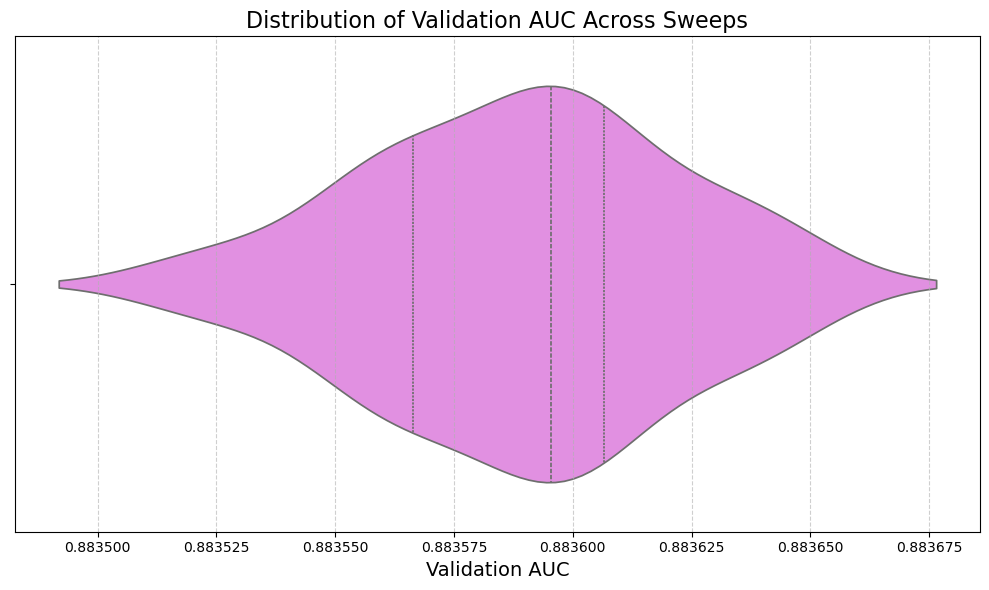

In [179]:
plt.figure(figsize=(10, 6))
sns.violinplot(x="Validation AUC", data=combined_sweeps, inner="quartile", color="violet")
plt.title("Distribution of Validation AUC Across Sweeps", fontsize=16)
plt.xlabel("Validation AUC", fontsize=14)
plt.grid(axis="x", linestyle="--", alpha=0.6)
plt.tight_layout()
plt.show()


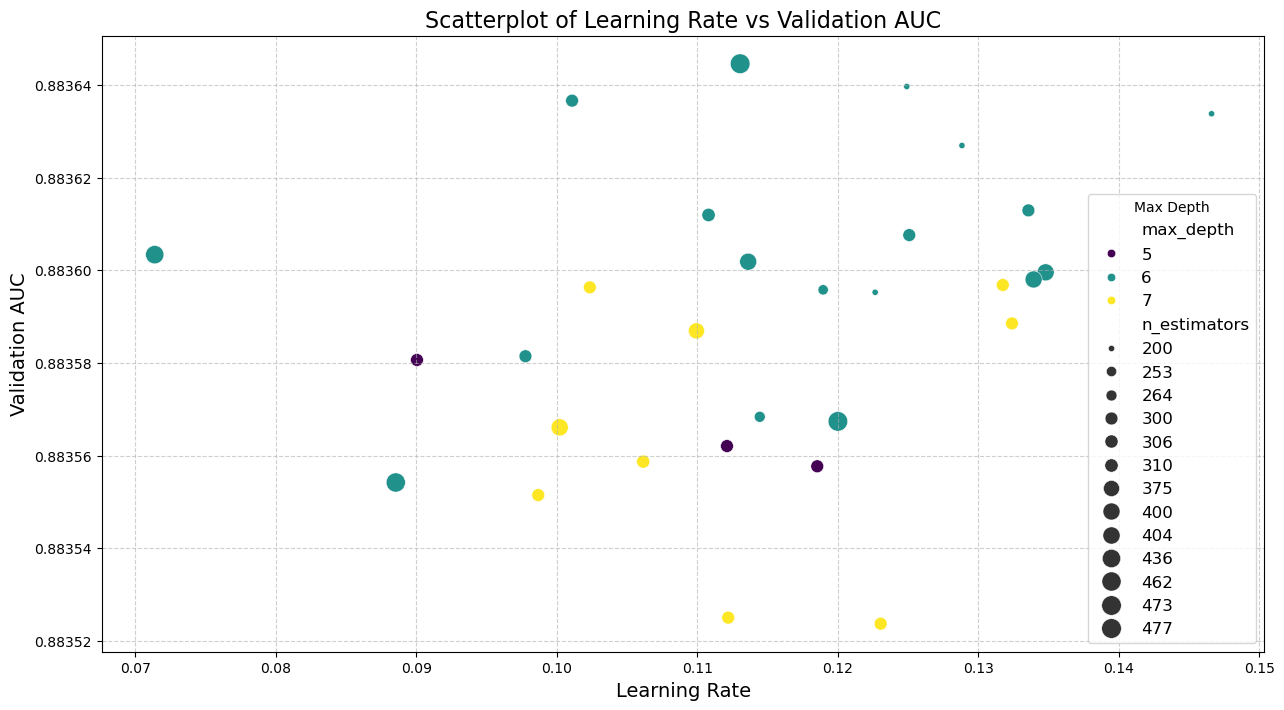

<Figure size 640x480 with 0 Axes>

In [201]:
plt.figure(figsize=(15, 8))
scatter = sns.scatterplot(
    data=combined_sweeps,
    x="learning_rate",
    y="Validation AUC",
    size="n_estimators",
    hue="max_depth",
    palette="viridis",
    sizes=(20, 200),
    legend="full"
)

scatter.set_title("Scatterplot of Learning Rate vs Validation AUC", fontsize=16)
scatter.set_xlabel("Learning Rate", fontsize=14)
scatter.set_ylabel("Validation AUC", fontsize=14)
scatter.legend(title="Max Depth", fontsize=12, loc="lower right")

plt.grid(True, linestyle="--", alpha=0.6)
plt.show()
plt.tight_layout()

<br>
<div style="background-color: #F8AE29; text-align: left; width: 100%; height: 2px;"></div>
<br>

# Interpretation of Result(s)

1. As we can see, a **`max_depth`** of 6 to 8 appears sufficient for producing better results, as deeper trees in previous runs showed diminishing returns.  
2. A **`learning_rate`** in the range of 0.1–0.15 yielded the best results during testing.  
3. A slightly higher value of **`n_estimators`** within the range of 200 to 400 achieved a good balance between model complexity and training speed.  
4. Fine-tuning **`subsample`** to 0.75–0.95 resulted in higher stability and better model performance.  
5. Reducing **`min_child_weight`** to the range of 3–6 seemed to highlight the most impactful values.  
6. Using **`colsample_bytree`** ensures that most features are considered during training, improving feature diversity.  
7. Experimentation with **`gamma`** regularization in the range of 0–2 did not have a significant impact on model performance.  
8. Prioritizing higher values for **`reg_alpha`** and **`reg_lambda`** contributed to more stable and robust models.  


<br>
<div style="background-color: #F8AE29; text-align: left; width: 100%; height: 2px;"></div>
<br>

<br>
<div style="background-color: #F8AE29; text-align: left; width: 100%; height: 2px;"></div>
<br>

> The as-trained XGBoost model is by nature a recursive if-else structure, in which a sample traverses from the head node
to a leaf node based on true/false statements of a particular
feature value. XGBoost is therefore more interpretable than
neural networks, the latter of which contains countless nonlinear feature combinations in neurons, making it hard to explain.
XGBoost is also known to be a more powerful model with
higher prediction accuracy on tabular datasets. This is one
of the reasons that we adopt XGBoost as our bottom-level
learning algorithm in the first place.

>Federated learning constructs a secure and collaborative
learning framework on top of machine learning algorithms,
so that all parties can jointly train a unified prediction model,
without having to share any local data. Horizontal and vertical
federated learning respectively address the separation of samples among homogeneous and heterogeneous parties.
>To the best of our knowledge, though, a comprehensive framework
that combines horizontal and vertical federated learning has
not been developed. The problem setup has demonstrated,
though, that it is likely for both types of data separation
to be present; beyond the power system domain, different
corporations also happen to possess data-holding branches
in the same set of local districts, and such a framework is
necessary for them to perform collaborative machine learning 

### Source: https://arxiv.org/pdf/2201.02783

<br>
<div style="background-color: #F8AE29; text-align: left; width: 100%; height: 2px;"></div>
<br>

# **Comparison Between the Two Best Models**

The model from **"devoted-sweep-39"** stands out as an attractive option, primarily due to its shorter runtime of **14.09 seconds** compared to **leafy-sweep-3**, which takes **15.36 seconds**. While both models achieve an identical Validation AUC of **0.88364**, the reduced runtime makes "devoted-sweep-39" a more efficient choice, especially in a production setting where time efficiency can significantly impact scalability and cost.

---

### **Detailed Comparison**

| Parameter            | Devoted-Sweep-39          | Leafy-Sweep-3         |
|----------------------|---------------------------|-----------------------|
| **Validation AUC**   | **0.88364**               | **0.88364**           |
| **Runtime (s)**      | **14.09**                 | **15.36**             |
| `colsample_bytree`   | 0.8631                    | 0.9468                |
| `gamma`              | **0**                     | 2                     |
| `learning_rate`      | **0.1466**                | 0.1249                |
| `max_depth`          | 6                         | 6                     |
| `min_child_weight`   | **6**                     | 5                     |
| `n_estimators`       | 200                       | 200                   |
| `reg_alpha`          | **0.9566**                | 0.9446                |
| `reg_lambda`         | **1.866**                 | 1.6                   |
| `subsample`          | **0.9383**                | 0.8204                |


<br>
<div style="background-color: #F8AE29; text-align: left; width: 100%; height: 2px;"></div>
<br>


### **Why Devoted-Sweep-39 Is the Better Choice**

The most compelling reason to choose the model "devoted-sweep-39" is its comparatively shorter runtime. Saving roughly **1.27 seconds** per run might seem minimal at first, but in a production scenario with large-scale operations, this efficiency gain becomes significant. Additionally, "devoted-sweep-39" benefits from slightly more robust regularization parameters. With `reg_alpha` at **0.9566** and `reg_lambda` at **1.866**, the model is better equipped to avoid overfitting, which is essential for maintaining performance on unseen data.<br><br>

Another factor favoring "devoted-sweep-39" is its higher learning rate of **0.1466**. This enables the model to adapt more quickly to the data without compromising the quality of predictions, as evidenced by the identical Validation AUC. Moreover, the model incorporates a larger subsample fraction of **0.9383**, allowing it to use more data per tree. This could enhance the generalization ability of the model, particularly in datasets with significantly more complex structures or noise.<br><br>

In contrast, while "leafy-sweep-3" performed comparably in terms of AUC, its use of a `gamma` value of **2** suggests a more conservative approach to tree splitting, which might limit flexibility in capturing certain patterns in the data. Furthermore, the lower subsample value of **0.8204** means it relies on less data for each tree, potentially affecting its ability to generalize effectively.<br><br>

With all that said, **"devoted-sweep-39"** ranks as first choice and as the superior choice for deployment in a Federated Learning setting focused on fraud detection.

<br>
<div style="background-color: #F8AE29; text-align: left; width: 100%; height: 2px;"></div>
<br>